In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user lazypredict

Note: you may need to restart the kernel to use updated packages.


In [3]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Base packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import string as st
%matplotlib inline

# Helper packages
import time
import os
import pickle
import re

# Preprocessing packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Machine Learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Scoring packages
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

## Tokenizer helper

Function which helps preserve special characters during tokenization

In [5]:
def tokenizer(x):
    r='!"#$%&;()*+,-./:;<=>?\'@[\\]^_`{|}~'
    to_replace=[re.escape(i) for i in r]

    replace_with=[' '+i+' ' for i in r]
    x=x.lower()
    x=pd.DataFrame([x])[0].replace(to_replace,replace_with,regex=True)[0]
    return(x)
 
corpus=pd.DataFrame(["That's an example.",
"Don't ignore it!",
"This is another example.",
"50$ is a price:-) !&!!^)",
"Look @predictivehacks for more hacks",
"These are hashtags #predictivehacks #datascience #100%fun"],columns=['sentences'])



In [6]:
seed = 170280378

In [7]:
os.getcwd()

'C:\\Users\\User\\Desktop\\PROJECT WORK\\Jupyter Repo'

In [8]:
# Read in XSS
df = pd.read_csv("XSS/XSS.csv")

In [9]:
# Quick inspection
df.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [10]:
# Can remove this column which is just a duplicate of existing index
df.drop(["Unnamed: 0"], inplace=True, axis=1)

In [11]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13686 entries, 0 to 13685
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  13686 non-null  object
 1   Label     13686 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 214.0+ KB


In [13]:
# showing missing values
print(df.isna().sum())
df[df.isna().any(axis=1)]

Sentence    0
Label       0
dtype: int64


,Sentence,Label


In [14]:
# Remove missing values

df.dropna(axis=0, inplace=True)

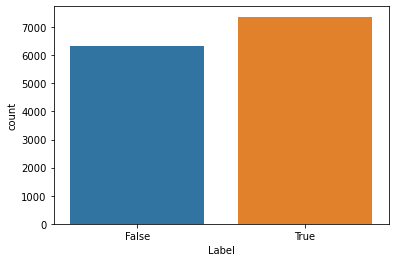

In [15]:
sns.countplot(df["Label"]==1)

In [16]:
# Well-balanced data set
(df["Label"] == 1).sum() / len(df["Label"])

0.5387257051001023


### CountVectorizer
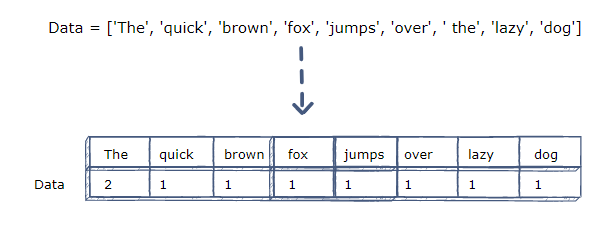

### Common hyperparameters

- min and max_df, ignore terms that have a frequency below or above a certain threshold. Default is 1 so no terms ignored.
- stop_words: Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. 

In [17]:
# Similar to SQLi, punctuation and stop words are common
df[df["Sentence"].str.contains("and")]

,Sentence,Label
2,"\t </span> <span class=""reference-text"">Steeri...",0
31,"<li><cite id=""CITEREFOudeyer2010"" class=""citat...",0
40,\t </span>. <i>Behavioral and Brain Sciences <...,0
42,"\t </span> <span class=""reference-text""><cite ...",0
84,"\t </span> <span class=""reference-text"">Celli,...",0
...,...,...
13589,<dd>Many of the things people know take the fo...,0
13611,"<li class=""toclevel-3 tocsection-62""><a href=""...",0
13612,"<command onkeydown=""alert(1)"" contenteditable>...",1
13677,"</p><p><a href=""/wiki/Default_logic"" title=""D...",0


In [18]:
# punctuation also features prominently
df[df["Sentence"].str.contains("'")]

,Sentence,Label
226,"<li><a href=""/wiki/Christof_Koch"" title=""Chris...",0
230,"\t </span> <span class=""reference-text""><cite ...",0
305,"d=""alert('');\"")"";",1
341,header('Location: '.$_GET['param']);,1
458,"</p><p>In 2011, a <i><a href=""/wiki/Jeopardy!...",0
...,...,...
13431,"\t </span> <span class=""reference-text""><cite ...",0
13437,"<STYLE>.{background-image:url(""javascript:aler...",1
13439,"<DIV STYLE=""background-image:\0075\0072\006C\0...",1
13457,"\t </span> <span class=""reference-text""><cite ...",0


# Size reduction
Standardise at 10, 000 rows total


In [19]:
df["Label"]

0        0
1        1
2        0
3        0
4        0
        ..
13681    1
13682    1
13683    1
13684    0
13685    0
Name: Label, Length: 13686, dtype: int64

In [20]:
df = df.groupby("Label").apply(pd.DataFrame.sample, frac=0.73067).reset_index(drop=True)

In [21]:
df["Sentence"] = df["Sentence"].apply(tokenizer)

In [22]:
# Still preserves the same ratio of values
(df["Label"] == 1).sum() / len(df["Label"])

0.5387

In [23]:
df

,Sentence,Label
0,"< li > < cite id = "" citerefpenrose1989 "" ...",0
1,"\t < div class = "" thumbinner "" style = "" ...",0
2,"\t < / span > < a href = "" / w / index . ...",0
3,"< section data - toggle = "" wy - nav - s...",0
4,"< ul > < li > < a rel = "" nofollow "" clas...",0
...,...,...
9995,"< fieldset onpaste = "" alert ( 1 ) "" conte...",1
9996,< style > @ keyframes slidein { } < / st...,1
9997,"< optgroup onmouseup = "" alert ( 1 ) "" > t...",1
9998,< style > @ keyframes x { } < / style > ...,1


In [24]:
X=df["Sentence"]

In [25]:
y=df["Label"]

In [26]:
# Since only one .csv, perform the full split here
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=seed)

In [27]:

cv = CountVectorizer(token_pattern="\S+")
tfv = TfidfVectorizer(token_pattern="\S+")


In [28]:
count_vect_train = cv.fit_transform(X_train)
tf_vect_train = tfv.fit_transform(X_train)

In [29]:
count_vect_test = cv.transform(X_test)
tf_vect_test = tfv.transform(X_test)

In [30]:
X_train = pd.DataFrame(count_vect_train.toarray())

In [31]:
X_test = pd.DataFrame(count_vect_test.toarray())

In [32]:
y_test

9961    1
9918    1
8440    1
1052    0
9725    1
       ..
6087    1
6428    1
4519    0
101     0
1696    0
Name: Label, Length: 2000, dtype: int64

# Hyperparameter tuning


In [33]:
cv_pickle = "XSS_cv_pickle.sav"
pickle.dump(cv, open(cv_pickle, "wb"))

In [34]:
time_taken = []

### Decision Tree

In [35]:
train_recall_score = []

In [36]:
decision_tree = DecisionTreeClassifier(random_state=seed)

In [37]:
dt_parameters = {'max_features': ['log2', 'sqrt','auto', None], 
              'criterion': ['entropy', 'gini'],
                 'splitter':['best', 'random'],
                'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 5, 10],
              'min_samples_leaf': [2, 3, 5, 10]
             }

In [38]:

best_dt = RandomizedSearchCV(decision_tree, dt_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
dt_start = time.time()
best_dt.fit(X_train, y_train)
dt_end = time.time()
dt_time_taken = (dt_end-dt_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini, score=1.000, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini, score=1.000, total=   0.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_feature

[CV]  splitter=best, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, criterion=gini, score=0.999, total=   0.4s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.2s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini, score=0.993, total=   0.4s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   12.6s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini, score=0.967, total=   0.4s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   13.1s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=b

[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=2, criterion=entropy, score=1.000, total=   0.4s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   37.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   37.5s finished


In [39]:
print(dt_time_taken)

0.7561665105819703


In [40]:
time_taken.append(dt_time_taken)

In [41]:
best_dt.best_params_

{'splitter': 'random',
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 2,
 'criterion': 'gini'}

In [42]:
dt_pickle = "XSS_dt_pickle.sav"
pickle.dump(best_dt, open(dt_pickle, "wb"))

In [43]:
dt_recall = best_dt.best_score_

In [44]:
dt_recall

1.0

In [45]:
train_recall_score.append(dt_recall)

In [46]:
train_recall_score

[1.0]

### Random Forest

In [47]:
random_forest = RandomForestClassifier(random_state=seed)

In [48]:
rf_parameters = {"n_estimators":[10, 50, 100],
                 "max_features":["log2", "sqrt", "auto", None],
                 "criterion":["entropy", "gini"],
                 "max_depth":[2, 3, 5, 10, 50],
                 "min_samples_split":[2, 3, 5],
                 "min_samples_leaf":[2, 3, 5]
}

In [49]:
best_rf = RandomizedSearchCV(random_forest, rf_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
rf_start = time.time()
best_rf.fit(X_train, y_train)
rf_end = time.time()
rf_time_taken = (rf_end-rf_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini, score=1.000, total=   0.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini, score=1.000, total=   0.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2

[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, score=0.995, total=   0.5s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 17.3min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini, score=0.997, total=   2.2s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 17.4min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini, score=0.990, total=   2.1s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 17.4min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV] 

[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=2, criterion=entropy, score=0.982, total= 1.1min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 34.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 34.1min finished


In [50]:
print(rf_time_taken)

40.904814882278444


In [51]:
time_taken.append(rf_time_taken)

In [52]:
best_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini'}

In [53]:
rf_pickle = "XSS_rf_pickle.sav"
pickle.dump(best_rf, open(rf_pickle, "wb"))


In [54]:
rf_recall = best_rf.best_score_

In [55]:
rf_recall

1.0

In [56]:
train_recall_score.append(rf_recall)

In [57]:
train_recall_score

[1.0, 1.0]

### SVC

In [58]:
svc = SVC(random_state=seed)

In [59]:
svc_parameters = {"kernel": ["linear", "rbf", "poly"],
                 "gamma": [0.1, 1, 10, 100],
                 "C": [0.1, 1, 10, 100, 1000],
                  "degree": [0, 1, 2, 3, 4, 5, 6]
}

In [60]:
best_svc = RandomizedSearchCV(svc, svc_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
svc_start = time.time()
best_svc.fit(X_train, y_train)
svc_end = time.time()
svc_time_taken = (svc_end-svc_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.995, total=  13.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.998, total=  12.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.999, total=  13.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.2s remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.999, total=  13.4s
[Parallel(n_jobs=1)]: Done   4

[CV]  kernel=poly, gamma=1, degree=0, C=10, score=1.000, total= 7.0min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 161.3min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=1.000, total= 7.0min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 168.3min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=1.000, total= 7.0min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 175.4min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=1.000, total= 7.0min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 182.3min remaining:    0.0s
[CV] kernel=rbf, gamma=100, degree=4, C=0.1 ..........................
[CV]  kernel=rbf, gamma=100, degree=4, C=0.1, score=1.000, total= 6.9min
[Parallel(n_jobs=1)]: Done  41 out 

In [61]:
print(svc_time_taken)

271.79444382667543


In [62]:
time_taken.append(svc_time_taken)

In [63]:
svc_pickle = "XSS_svc_pickle.sav"
pickle.dump(best_svc, open(svc_pickle, "wb"))


In [64]:
best_svc.best_params_

{'kernel': 'poly', 'gamma': 100, 'degree': 0, 'C': 1000}

In [65]:
svc_recall = best_svc.best_score_

In [66]:
svc_recall

1.0

In [67]:
train_recall_score.append(svc_recall)

In [68]:
train_recall_score

[1.0, 1.0, 1.0]

## Logistic REgression

In [69]:
lr = LogisticRegression(random_state=seed)

In [70]:
lr_parameters = {
     'penalty' : ["l2", None],
    'C' : [0.1, 1.0, 10, 100],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter":[5, 10, 25, 50, 75, 100],
    "multi_class": ["auto", "ovr", "multinomial"]
}

In [71]:
best_lr = RandomizedSearchCV(lr, lr_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
lr_start = time.time()
best_lr.fit(X_train, y_train)
lr_end = time.time()
lr_time_taken = (lr_end-lr_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, 

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  6.4min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  6.4min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.1s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  6.4min remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=1.0 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=1.0, score=nan, total=   0.3s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.5min remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=1.0 
[CV]  solver=liblinear, penalt

In [72]:
print(lr_time_taken)

8.132316732406617


In [73]:
time_taken.append(lr_time_taken)

In [74]:
best_lr.best_params_

{'solver': 'newton-cg',
 'penalty': 'l2',
 'multi_class': 'multinomial',
 'max_iter': 50,
 'C': 0.1}

In [75]:
lr_pickle = "XSS_lr_pickle.sav"
pickle.dump(best_lr, open(lr_pickle, "wb"))

In [76]:
lr_recall = best_lr.best_score_

In [77]:
lr_recall

0.992609699769053

In [78]:
train_recall_score.append(lr_recall)

In [79]:
train_recall_score

[1.0, 1.0, 1.0, 0.992609699769053]

## KNeighbours

In [80]:
knn = KNeighborsClassifier()

In [81]:
knn_parameters = {"n_neighbors": [1, 5, 10, 25, 50, 75, 100],
                  "weights": ["uniform", "distance"],
                  "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                  "leaf_size": [1, 5, 10, 20, 30, 35, 50]
    
}

In [82]:
best_knn = RandomizedSearchCV(knn, knn_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
knn_start = time.time()
best_knn.fit(X_train, y_train)
knn_end = time.time()
knn_time_taken = (knn_end-knn_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.964, total= 1.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.971, total= 1.6min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.976, total= 1.6min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=un

[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.976, total= 1.1min
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 19.8min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto ..
[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.982, total= 1.2min
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 20.9min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto ..
[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.969, total= 1.1min
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 22.0min remaining:    0.0s
[CV] weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree .
[CV]  weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree, score=0.965, total= 1.8min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 23.8min remaining:    0.0s
[CV] weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree .
[CV]  w

In [83]:
print(knn_time_taken)

52.319371671676635


In [84]:
time_taken.append(knn_time_taken)

In [85]:
best_knn.best_params_

{'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 5, 'algorithm': 'brute'}

In [86]:
knn_pickle = "XSS_knn_pickle.sav"
pickle.dump(best_knn, open(knn_pickle, "wb"))

In [87]:
knn_recall = best_knn.best_score_

In [88]:
knn_recall

0.997228637413395

In [89]:
train_recall_score.append(knn_recall)

In [90]:
train_recall_score

[1.0, 1.0, 1.0, 0.992609699769053, 0.997228637413395]

## Multinomial NB

Special case with few hyperparameters to tune (Reduced)

In [91]:
nb = MultinomialNB()

In [92]:
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [93]:
nb_parameters = {"alpha": [0, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  "class_prior": [None],
                  "fit_prior": [True, False]
    
}

In [94]:
best_nb = RandomizedSearchCV(nb, nb_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
nb_start = time.time()
best_nb.fit(X_train, y_train)
nb_end = time.time()
nb_time_taken = (nb_end-nb_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.992, total=   1.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.991, total=   1.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.997, total=   1.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.998, total=   1.3s
[Parallel(

[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.984, total=   1.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   36.8s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.986, total=   1.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   37.8s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.993, total=   1.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   38.8s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.994, total=   1.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   39.8s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.988, total=   1.0s
[Paral

In [95]:
print(nb_time_taken)

1.0358105278015137


In [96]:
time_taken.append(nb_time_taken)

In [97]:
best_nb.best_params_

{'fit_prior': True, 'class_prior': None, 'alpha': 0.1}

In [98]:
nb_pickle = "XSS_nb_pickle.sav"
pickle.dump(best_nb, open(nb_pickle, "wb"))

In [99]:
nb_recall = best_nb.best_score_

In [100]:
nb_recall

0.9958429561200924

In [101]:
train_recall_score.append(nb_recall)

In [102]:
train_recall_score

[1.0, 1.0, 1.0, 0.992609699769053, 0.997228637413395, 0.9958429561200924]

## MLPClassifier

In [103]:
nn = MLPClassifier(random_state=seed)

In [104]:
nn.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [105]:
nn_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ["identity", "logistic", "tanh", "relu"],
    'solver': ['sgd', 'adam'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive', "invscaling"],
    "learning_rate_init": [0.001, 0.01]
}
    


In [106]:
best_nn = RandomizedSearchCV(nn, nn_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
nn_start = time.time()
best_nn.fit(X_train, y_train)
nn_end = time.time()
nn_time_taken = (nn_end-nn_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity, score=0.992, total= 2.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity, score=0.990, total= 2.4min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.2min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50

[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.992, total= 4.5min
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 36.0min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.993, total= 4.5min
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 40.5min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.988, total= 4.5min
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 45.0min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=

[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=0.997, total=  33.1s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed: 62.3min remaining:    0.0s
[CV] solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic 
[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=0.997, total= 1.1min
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 63.3min remaining:    0.0s
[CV] solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic 
[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=0.999, total=  33.8s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 63.9min remaining:    0.0s
[CV] s

In [107]:
print(nn_time_taken)

80.4831060743332


In [108]:
time_taken.append(nn_time_taken)

In [109]:
best_nn.best_params_

{'solver': 'sgd',
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 100, 50),
 'alpha': 0.0001,
 'activation': 'logistic'}

In [110]:
nn_pickle = "XSS_nn_pickle.sav"
pickle.dump(best_nn, open(nn_pickle, "wb"))

In [111]:
nn_recall = best_nn.best_score_

In [112]:
nn_recall

1.0

In [113]:
train_recall_score.append(nn_recall)

In [114]:
train_recall_score

[1.0, 1.0, 1.0, 0.992609699769053, 0.997228637413395, 0.9958429561200924, 1.0]

## XGBClassifier

In [115]:
xgb = XGBClassifier(random_state=seed)

In [116]:
xgb.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [117]:
xgb_parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
}
    


In [118]:
best_xgb = RandomizedSearchCV(xgb, xgb_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
xgb_start = time.time()
best_xgb.fit(X_train, y_train)
xgb_end = time.time()
xgb_time_taken = (xgb_end-xgb_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=0.993, total=  19.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s remaining:    0.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=0.991, total=  19.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.9s remaining:    0.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=0.998, total=  19.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.4s remaining:    0.0s
[CV] subsample=0.8, min_child_

[CV]  subsample=0.8, min_child_weight=10, max_depth=4, gamma=5, colsample_bytree=0.8, score=0.988, total=  26.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.8min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.993, total=  20.3s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 13.2min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.987, total=  20.4s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 13.5min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.997, total=  20.6s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 13.9mi

In [119]:
print(xgb_time_taken)

26.484522128105162


In [120]:
time_taken.append(xgb_time_taken)

In [121]:
best_xgb.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 6,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [122]:
xgb_pickle = "XSS_xgb_pickle.sav"
pickle.dump(best_xgb, open(xgb_pickle, "wb"))

In [123]:
xgb_recall = best_xgb.best_score_

In [124]:
xgb_recall

0.997228637413395

In [125]:
train_recall_score.append(xgb_recall)

In [126]:
train_recall_score

[1.0,
 1.0,
 1.0,
 0.992609699769053,
 0.997228637413395,
 0.9958429561200924,
 1.0,
 0.997228637413395]

# Example confusion matrix

# Load in test data

In [127]:
time_taken

[0.7561665105819703,
 40.904814882278444,
 271.79444382667543,
 8.132316732406617,
 52.319371671676635,
 1.0358105278015137,
 80.4831060743332,
 26.484522128105162]

In [128]:
train_recall_score

[1.0,
 1.0,
 1.0,
 0.992609699769053,
 0.997228637413395,
 0.9958429561200924,
 1.0,
 0.997228637413395]

In [129]:
test_recall_scores = []
prediction_time = []

In [130]:
classifiers = [best_dt, best_rf, best_svc, best_lr, best_knn, best_nb, best_nn, best_xgb]

In [131]:
for i in classifiers:
    start = time.time()
    y_test_pred = i.predict(X_test)
    end = time.time()
    prediction_time.append(end-start)
    test_recall_score = recall_score(y_test, y_test_pred)
    test_recall_scores.append(test_recall_score)

In [132]:
test_recall_scores

[1.0,
 1.0,
 1.0,
 0.9914853358561968,
 0.9971617786187322,
 0.9924314096499527,
 1.0,
 0.9952696310312205]

In [133]:
results =   {"Algorithm": ["Decision Tree", "Random Forest", "Support Vector Machine", "Logistic Regression",
                               "K Nearest Neighbours", "Naive Bayes", "Neural Network", "XGBoost"],
        "Training/Validation Recall": train_recall_score,
        "Testing Recall": test_recall_scores
       }
  


    
    


In [134]:
times = {"Algorithm": ["Decision Tree", "Random Forest", "Support Vector Machine", "Logistic Regression",
                               "K Nearest Neighbours", "Naive Bayes", "Neural Network", "XGBoost"],
         
         "Average training time" : time_taken,
         "Prediction time": prediction_time
            

       
}

In [135]:
results_df = pd.DataFrame(results)

In [136]:
results_df

,Algorithm,Training/Validation Recall,Testing Recall
0,Decision Tree,1.00,1.00
1,Random Forest,1.00,1.00
2,Support Vector Machine,1.00,1.00
3,Logistic Regression,0.99,0.99
4,K Nearest Neighbours,1.00,1.00
5,Naive Bayes,1.00,0.99
6,Neural Network,1.00,1.00
7,XGBoost,1.00,1.00


In [137]:
results_df.to_pickle("XSS Results Pickle")

In [138]:
results_df.sort_values(by="Training/Validation Recall", inplace=True)

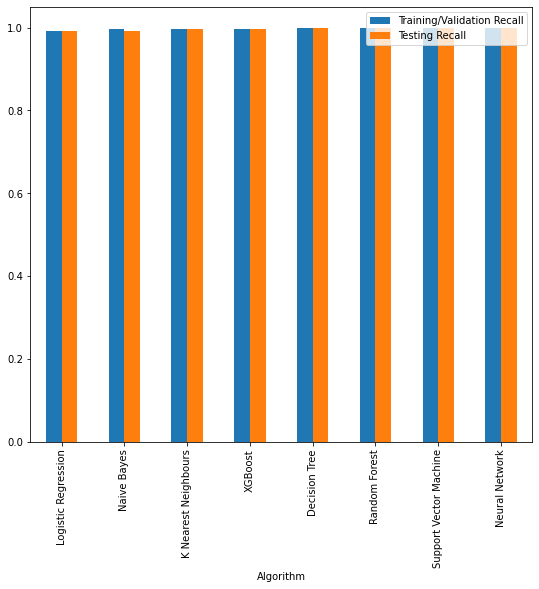

In [139]:
results_df.plot(x="Algorithm", y=["Training/Validation Recall", "Testing Recall"], kind="bar", figsize=(9,8))

In [140]:
results_df.sort_values(by="Testing Recall", inplace=True)

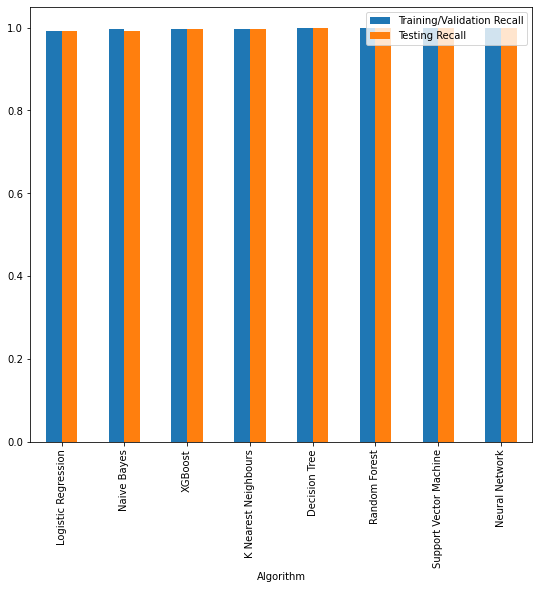

In [141]:
results_df.plot(x="Algorithm", y=["Training/Validation Recall", "Testing Recall"], kind="bar", figsize=(9,8))

In [142]:
time_df = pd.DataFrame(times)

In [143]:
time_df

,Algorithm,Average training time,Prediction time
0,Decision Tree,0.76,0.18
1,Random Forest,40.90,0.11
2,Support Vector Machine,271.79,130.12
3,Logistic Regression,8.13,0.07
4,K Nearest Neighbours,52.32,2.10
5,Naive Bayes,1.04,0.08
6,Neural Network,80.48,0.10
7,XGBoost,26.48,0.37


In [144]:
time_df.to_pickle("XSS Time Pickle")

In [145]:
time_df.sort_values(by="Prediction time", inplace=True)

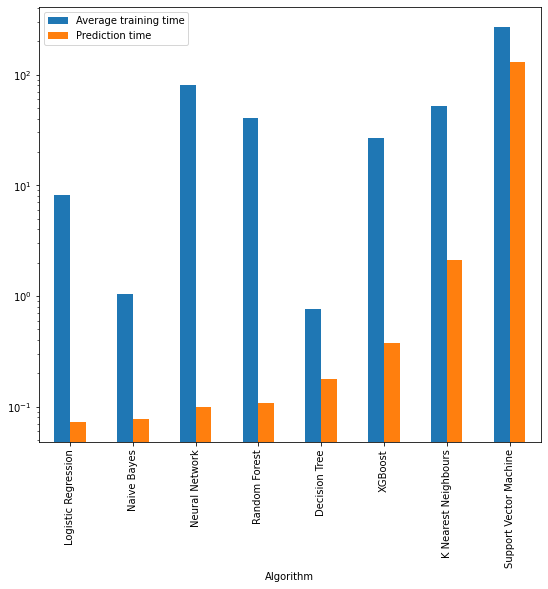

In [146]:
time_df.plot(x="Algorithm", y=["Average training time", "Prediction time"], kind="bar", figsize=(9,8), logy=True)